<a href="https://colab.research.google.com/github/dattali18/IR_Assignments/blob/main/Assignment.02/notebooks/IR_02_Clustering_SBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

## 1. Objective

Take the document (meaning vector representation of the document, the ouput of the last assginment `Doc2Vec`, `BERT`, `Sentence-BERT`, times 4 group from each) and cluster them into groups and compare the results with the actuale division form each publication.

## 2. Input

4 Groups of matrices each line repesent a document in it's vector form, from:

1. `Doc2Vec`
2. `BERT`
3. `Sentence-BERT`

### 3. Task

  - Combine the four matrices into a single matrix for each technique.
  - Apply clustering using:
    - **K-Means** (with `k=4` for 4 journals).
    - **DBSCAN** (select `eps` and `min_samples` heuristically).
    - **Gaussian Mixture Model**.
  - Evaluate the clusters using:
    - Metrics: Precision, Recall, F1-Score, Accuracy.
    - Visualization: Use UMAP, t-SNE, or other tools (e.g., Seaborn).


### 4. Output

- The plot of the real clusters vs. the clusters from the 3 methods mentioned above.
- The metrics for each clustering method.

# Doc2Vec Matrices

We have 4 `.csv` files with each $(100, \approx 600)$ and we need to combine them into one big matrix and then cluster them.

## Plan

1. Download the files from my `GitHub`.
2. Add a `'cluster'` column for each file (`=0` for AJ etc...).
3. Cluster with `Kmeans` for `k=4`.
4. Write a function to find the right parameters for 4 clusters for `DBSCAN` (i.e. the `eps` and `min_samples` parameters).
5. Cluster with `DBSCAN`
6. Cluster with `GMM`
7. Use `t-SNE` to visualize the cluster in $\mathbb{R}^2$
8. Output the plot for each clustering methods + original
9. Measure each method using the metric mentioned above.

In [1]:
import warnings

warnings.filterwarnings("ignore")

Download the files from my `GitHub`

In [2]:
sbert_link = "https://github.com/dattali18/IR_Assignments/blob/main/Assignment.02/data/bert-sbert/sbert_vectors.csv?raw=true"

In [4]:
import pandas as pd

# download the data using the link
df_original = pd.read_csv(sbert_link)
df_original.head()

,Sheet,RowIndex,Dim0,Dim1,Dim2,Dim3,Dim4,Dim5,Dim6,Dim7,...,Dim374,Dim375,Dim376,Dim377,Dim378,Dim379,Dim380,Dim381,Dim382,Dim383
0,A-J,0,0.004812,0.026923,0.015163,0.007640,-0.012498,0.010280,0.012724,-0.018092,...,0.008701,0.016885,0.008800,0.008313,0.008201,0.011964,0.007581,-0.013848,-0.011848,-0.001732
1,A-J,1,0.014052,0.029228,0.007936,-0.016101,-0.013189,-0.001558,-0.003385,-0.022059,...,0.021585,-0.000603,-0.018857,-0.014222,-0.011867,0.018346,0.023300,-0.006670,-0.005978,-0.006608
2,A-J,2,0.022085,0.010386,0.011578,-0.003908,0.006717,-0.004299,0.003057,-0.019972,...,0.012670,-0.010248,-0.031286,-0.005751,0.011272,0.025057,0.023119,-0.002533,-0.021188,0.009121
3,A-J,3,0.014390,0.033544,0.001297,-0.012795,0.030116,-0.001583,0.001665,-0.034225,...,0.000973,0.007662,-0.006293,0.002391,-0.021095,0.000995,0.030528,-0.000011,-0.000507,-0.014717
4,A-J,4,0.008542,0.048237,-0.007828,-0.007906,-0.001495,-0.015571,-0.003299,-0.019079,...,0.004528,0.000808,-0.002086,-0.010071,0.007890,0.029334,0.019566,0.002759,0.001877,-0.011802


In [5]:
# create a new df where whe have the following column
# 1. Sheet with the name 'A-J', 'BBC', 'J-P', 'NY-T'
# 2. RowIndex - int
# 3. vector the numpy vector represntation (get all the value from Dim0 - Dim383 and make a list from them)

df = pd.DataFrame()

df['Sheet'] = df_original['Sheet']

df['vector'] = df_original.iloc[:, 2:].values.tolist()

df.head()

,Sheet,vector
0,A-J,"[0.0048119747079908, 0.0269228070974349, 0.015..."
1,A-J,"[0.014051909558475, 0.0292279813438653, 0.0079..."
2,A-J,"[0.0220847800374031, 0.0103860776871442, 0.011..."
3,A-J,"[0.0143899163231253, 0.0335444100201129, 0.001..."
4,A-J,"[0.0085417730733752, 0.0482366234064102, -0.00..."


In [ ]:
df = df_new

In [6]:
# standerdize the data mean=0 std=1

from sklearn.preprocessing import StandardScaler
import numpy as np


scaler = StandardScaler()

# apply to each line of the df

df['std_vector'] = df['vector'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())
df['std_vector'].head()

,std_vector
0,"[0.33769827578570766, 1.9186505569411698, 1.07..."
1,"[1.1357293086135947, 2.364315669413121, 0.6405..."
2,"[1.4762320509213087, 0.6868184955137784, 0.767..."
3,"[1.004912208125632, 2.3412263212831683, 0.0915..."
4,"[0.6223741096931129, 3.4501298118439143, -0.54..."


In [7]:
cluster_map = {'A-J': 0, 'BBC': 1, 'J-P': 2, 'NY-T': 3}
df['cluster'] = df['Sheet'].map(cluster_map)

In [8]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

In [9]:
# visualize the real cluster using t-SNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)

# transofrm the df['vector'] to dataframe with freatuer 0 - 299 for
df_copy = df['std_vector'].apply(pd.Series)

df_tsne = tsne.fit_transform(df_copy)

df_tsne = pd.DataFrame(df_tsne, columns=['x', 'y'])

df_tsne['cluster'] = df['cluster']

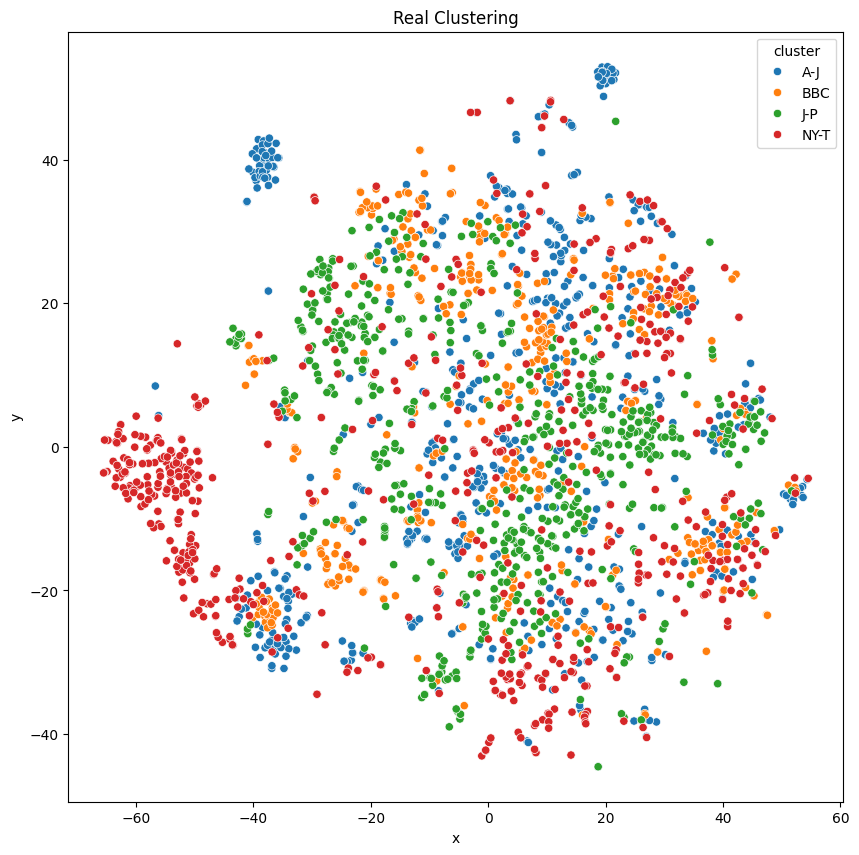

In [10]:
# plot the df_tsne

reverse_cluster_map = {v: k for k, v in cluster_map.items()}

plt.figure(figsize=(10, 10))
# add labels
plt.title('Real Clustering')

# make color scheme red, blue, green etc


df_tsne['cluster'] = df_tsne['cluster'].map(reverse_cluster_map)

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster')

plt.show()

### Kmeans

In [11]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df['std_vector'].tolist())

df['cluster_kmeans'] = kmeans.labels_

df['cluster_kmeans'].head()

,cluster_kmeans
0,0
1,2
2,0
3,1
4,3


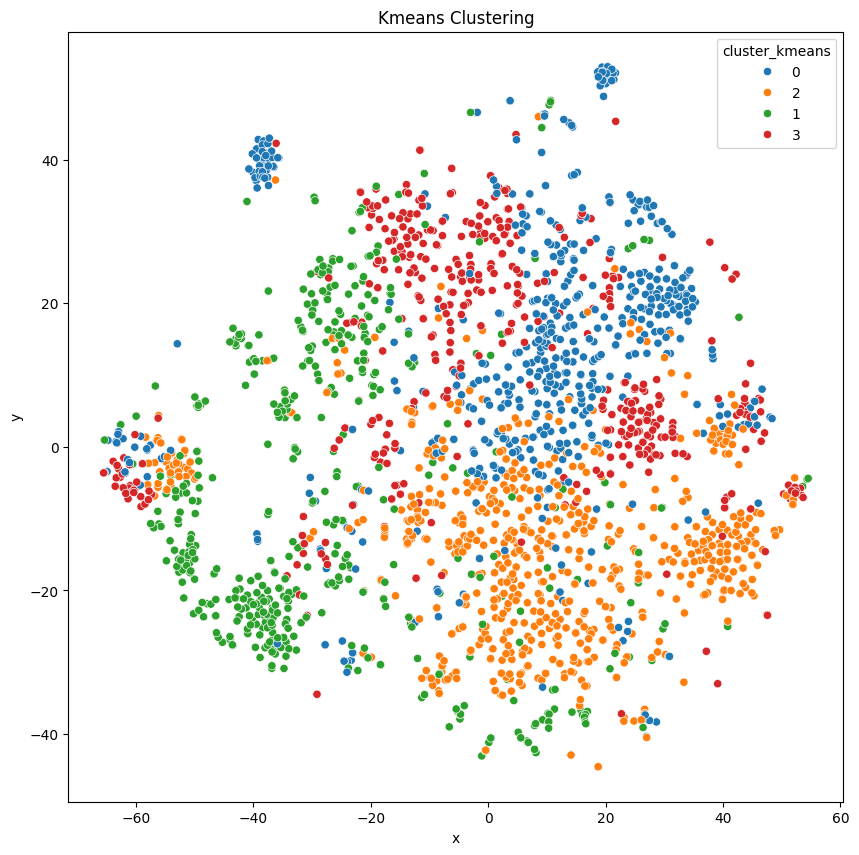

In [12]:
# visutalize the cluster using the t-SNE df

df_tsne['cluster_kmeans'] = df['cluster_kmeans']

reverse_cluster_map = {v: k for k, v in cluster_map.items()}

plt.figure(figsize=(10, 10))

plt.title('Kmeans Clustering')

# make color scheme red, blue, green etc


df_tsne['cluster_kmeans'] = df_tsne['cluster_kmeans'].map(str)

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster_kmeans')

plt.show()

### DBSCAN

In [13]:
!pip install kneed

In [14]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import DBSCAN

def get_parameters(df, num_clusters=4, eps_adjustment=1.0, min_samples_adjustment=1):
    X = np.array(df)

    # Use NearestNeighbors to find the nearest neighbors
    neighbors = NearestNeighbors(n_neighbors=2 * X.shape[1] - 1)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    # Use KneeLocator to find the "elbow" point in the k-distance graph
    kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
    eps = distances[kneedle.elbow] * eps_adjustment

    # Set min_samples to 2 * dimensions, another common heuristic
    min_samples = 2 * X.shape[1] * min_samples_adjustment

    return eps, min_samples

def find_best_parameters(df, num_clusters=4):
    best_eps = None
    best_min_samples = None
    best_num_clusters = 0

    for eps_adjustment in np.arange(0.5, 2.0, 0.1):
        for min_samples_adjustment in range(1, 5):
            eps, min_samples = get_parameters(df, num_clusters, eps_adjustment, min_samples_adjustment)
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
            labels = db.labels_
            num_clusters_found = len(set(labels)) - (1 if -1 in labels else 0)

            if num_clusters_found == num_clusters:
                return eps, min_samples

            if num_clusters_found > best_num_clusters:
                best_eps = eps
                best_min_samples = min_samples
                best_num_clusters = num_clusters_found

    return best_eps, best_min_samples

eps, min_samples = find_best_parameters(df['std_vector'].tolist(), num_clusters=4)
print(f"Best eps: {eps}, Best min_samples: {min_samples}")

Best eps: 17.583621196825618, Best min_samples: 768


In [15]:
# use DBSCAN

dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(df['std_vector'].tolist())

df['cluster_dbscan'] = dbscan.labels_

In [16]:
# count the number of cluster

num_clusters = len(df['cluster_dbscan'].unique())

print(f"Number of clusters: {num_clusters}")

Number of clusters: 2


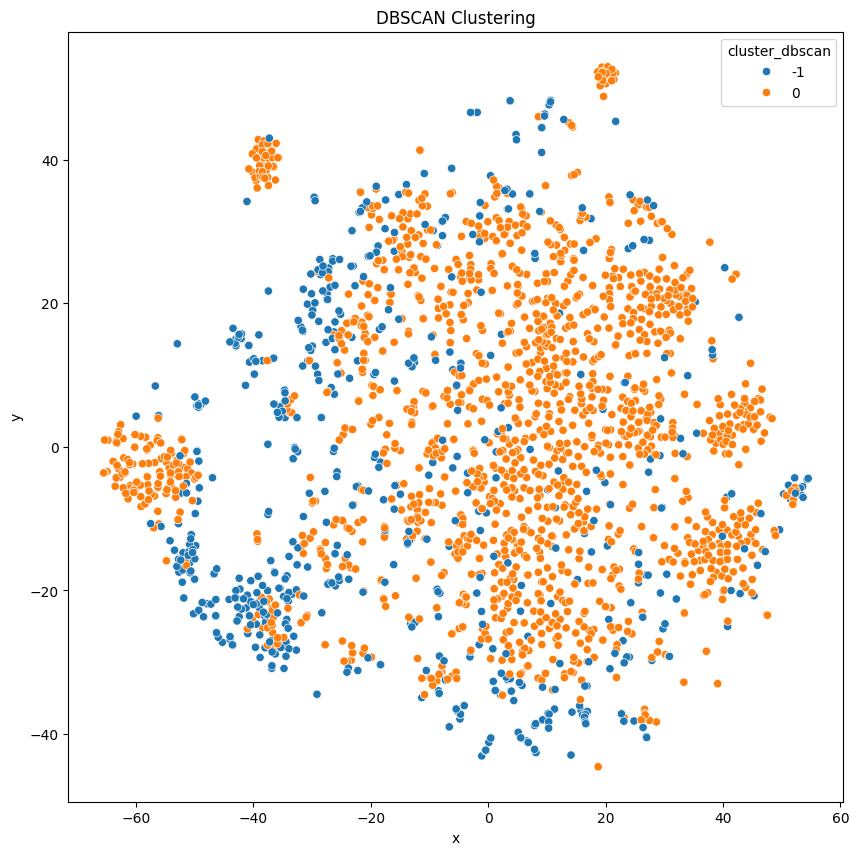

In [17]:
# visualize data

# visutalize the cluster using the t-SNE df

df_tsne['cluster_dbscan'] = df['cluster_dbscan']

reverse_cluster_map = {v: k for k, v in cluster_map.items()}

plt.figure(figsize=(10, 10))

plt.title('DBSCAN Clustering')

# make color scheme red, blue, green etc


df_tsne['cluster_dbscan'] = df_tsne['cluster_dbscan'].map(str)

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster_dbscan')

plt.show()

### GMM

In [18]:
# apply GMM

gmm = GaussianMixture(n_components=4, random_state=0).fit(df['std_vector'].tolist())

df['cluster_gmm'] = gmm.predict(df['std_vector'].tolist())

df['cluster_gmm'].head()


,cluster_gmm
0,0
1,2
2,0
3,1
4,3


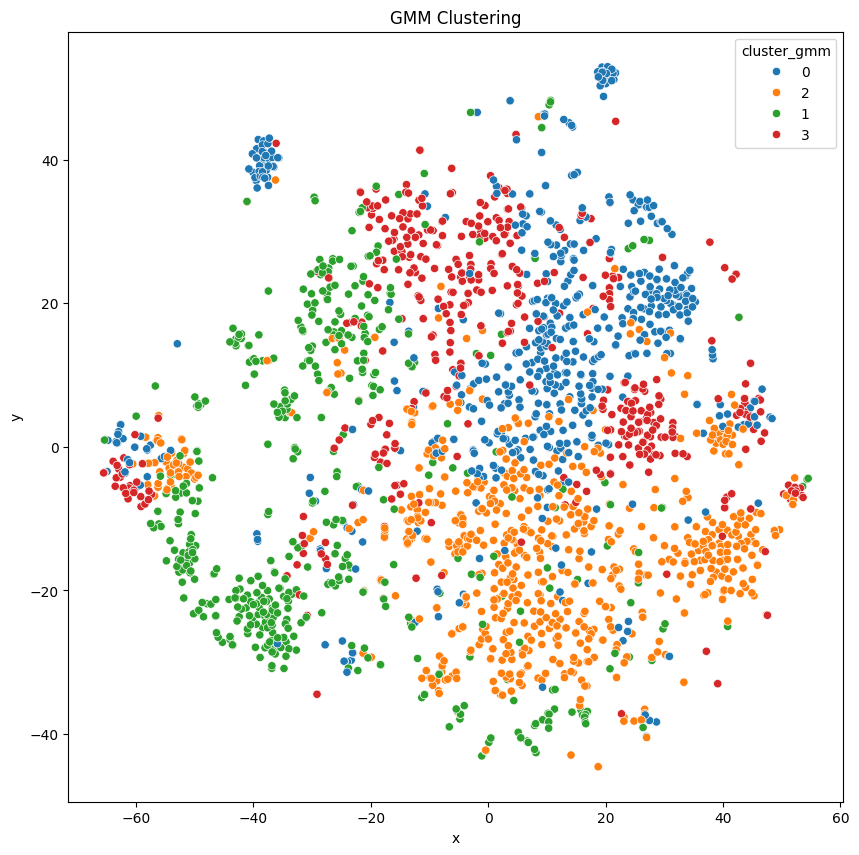

In [19]:
# visualize data

# visutalize the cluster using the t-SNE df

df_tsne['cluster_gmm'] = df['cluster_gmm']

reverse_cluster_map = {v: k for k, v in cluster_map.items()}

plt.figure(figsize=(10, 10))

plt.title('GMM Clustering')

# make color scheme red, blue, green etc


df_tsne['cluster_gmm'] = df_tsne['cluster_gmm'].map(str)

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster_gmm')

plt.show()

## Measurements

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evluate_model(real, pred):
    precision = precision_score(real, pred, average='macro')
    recall = recall_score(real, pred, average='macro')
    f1 = f1_score(real, pred, average='macro')
    accuracy = accuracy_score(real, pred)

    return precision, recall, f1, accuracy

In [21]:
kmeans_evalutation_df = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

kmeans_evalutation_df.loc['kmeans'] = evluate_model(df['cluster'], df['cluster_kmeans'])

kmeans_evalutation_df

,precision,recall,f1,accuracy
kmeans,0.262264,0.27372,0.266735,0.276215


In [22]:
# same for DBSCAN but map -1 to 2
df['cluster_dbscan'] = df['cluster_dbscan'].map(lambda x: x if x != -1 else 2)

dbscan_evalutation_df = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

dbscan_evalutation_df.loc['dbscan'] = evluate_model(df['cluster'], df['cluster_dbscan'])

dbscan_evalutation_df

,precision,recall,f1,accuracy
dbscan,0.116767,0.241653,0.148723,0.246803


In [23]:
# same for GMM

gmm_evalutation_df = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

gmm_evalutation_df.loc['gmm'] = evluate_model(df['cluster'], df['cluster_gmm'])

gmm_evalutation_df

,precision,recall,f1,accuracy
gmm,0.262232,0.27372,0.266698,0.276215
